In [1]:
import pandas as pd 
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error 

In [2]:
# Dados de entrada
path = "C:\\ENS\\Hidrologia"
dados = pd.read_excel(path+'\\Dados_ANA.xlsx')
dados = dados.set_index('Data') 
#dados.info()

In [3]:
# Separando máximas anuais 
dados = dados.groupby(dados.index.year).max()   

In [4]:
dados['Ordem i'] = range(1, len(dados['ln(Vazão)'])+1)
dados['Q ord (m³/s)'] = sorted(dados['Vazão'], reverse=True)
dados['ln(Q ord)'] = sorted(dados['ln(Vazão)'], reverse=True)
dados['Tr empírico (anos)'] = (len(dados['ln(Vazão)'])+1)/dados['Ordem i'] 
dados.head() 

,Vazão,ln(Vazão),Ordem i,Q ord (m³/s),ln(Q ord),Tr empírico (anos)
Data,,,,,,
1980,502.7077,6.220009,1,1077.3507,6.982260,37.000000
1981,580.6066,6.364073,2,971.6529,6.878999,18.500000
1982,803.3920,6.688843,3,962.8472,6.869895,12.333333
1983,962.8472,6.869895,4,930.0946,6.835286,9.250000
1984,500.9865,6.216579,5,887.0893,6.787946,7.400000


In [5]:
def lognormal(alfa, beta, Kp):
    return np.exp(alfa+beta*Kp)

alfa = dados['ln(Vazão)'].mean()
beta = dados['ln(Vazão)'].std()

Tr = np.exp(np.linspace(np.log(1.001), np.log(100), 300))
modelo = pd.DataFrame(data=Tr, columns=['Tr (anos)'])
modelo['aux'] = 2*(1-(1/modelo['Tr (anos)']))-1
modelo['Kp'] = (2**(1/2))*scipy.special.erfinv(modelo['aux'])
modelo['Q lognormal (m³/s)'] = lognormal(alfa, beta, modelo['Kp'])
modelo.head() 

,Tr (anos),aux,Kp,Q lognormal (m³/s)
0,1.001000,-0.998002,-3.090529,153.673794
1,1.016533,-0.967471,-2.137853,229.956159
2,1.032308,-0.937407,-1.862073,258.414593
3,1.048327,-0.907802,-1.683917,278.645061
4,1.064594,-0.878650,-1.549132,294.996531


In [6]:
# Intervalo de confiança
modelo['aux1'] = (1+(modelo['Kp']**2)/2)**(1/2)
modelo['EP'] = beta*modelo['aux1']/(len(modelo['aux1'])**(1/2))
modelo['Limite inf'] = np.exp(np.log(modelo['Q lognormal (m³/s)'])-(1.96*modelo['EP']))
modelo['Limite sup'] = np.exp(np.log(modelo['Q lognormal (m³/s)'])+(1.96*modelo['EP'])) 

In [7]:
# RMSE
aux = [2*(1-(1/i))-1 for i in dados['Tr empírico (anos)']]
Kp = [(2**(1/2))*scipy.special.erfinv(i) for i in aux]
y_pred = [lognormal(alfa, beta, i) for i in Kp]
print('RMSE = '+str(root_mean_squared_error(dados['Q ord (m³/s)'], y_pred)))

RMSE = 60.08155110770002


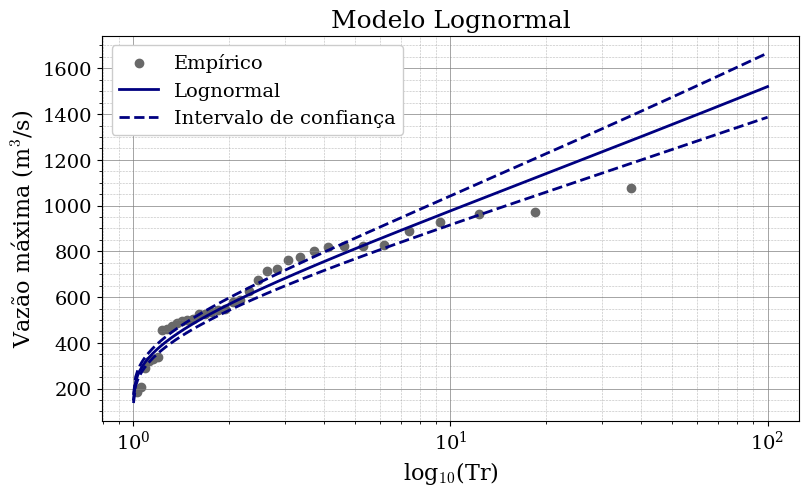

In [9]:
fig,ax = plt.subplots(figsize=(9,5)) 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'  

ax.scatter(dados['Tr empírico (anos)'], 
           dados['Q ord (m³/s)'],
           color='dimgray',
           label = 'Empírico')

ax.plot(modelo['Tr (anos)'], 
        modelo['Q lognormal (m³/s)'], 
        color='navy', 
        linewidth=2,
        label = 'Lognormal') 

ax.plot(modelo['Tr (anos)'], 
        modelo['Limite inf'], 
        color='navy', 
        linewidth=2,
        linestyle='--') 
ax.plot(modelo['Tr (anos)'], 
        modelo['Limite sup'], 
        color='navy', 
        linewidth=2,
        linestyle='--',
        label = 'Intervalo de confiança') 


plt.xscale('log') 
plt.title('Modelo Lognormal', size = 18)
plt.xlabel(r'log$_{10}$(Tr)', size = 16)
plt.ylabel(r'Vazão máxima (m$^3$/s)', size = 16)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
ax.grid(True,
        which='major', 
        color='gray', 
        linestyle='-',
        linewidth=0.5)
ax.grid(True,
        which='minor', 
        color='gray', 
        linestyle=':',
        linewidth=0.4)
ax.minorticks_on()
plt.legend(fontsize=14, framealpha=1) 
plt.savefig(path+'\\lognormal.png', bbox_inches='tight') 